In [39]:
import pandas as pd
import numpy  as np

import data file

In [40]:
df = pd.read_csv('data_new.csv')
df.describe()

,Label
count,329.000000
mean,0.589666
std,0.492644
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


split data

In [41]:
print("Non-cheat: ", len(df[df['Label']==0]))
print("Cheat: ", len(df[df['Label']==1]))

# diff = abs(len(df[df['Label']==0]) - len(df[df['Label']==1]))

grouped = df.groupby(df.Label)
df1 = grouped.get_group(1)
df2 = grouped.get_group(0)

df2_1 = df2.iloc[:135,:]
df2_2 = df2.iloc[135:194,:]

df1_train = df1.iloc[:111,:]
df2_train = df2_1.iloc[:111,:]

df1_test = df1.iloc[111:135,:]
df2_test = df2_1.iloc[111:135,:]

train = pd.concat([df1_train, df2_train])
test  = pd.concat([df1_test, df2_test, df2_2])

# shuffle data
train = train.sample(frac=1)
test  = test.sample(frac=1)

print((len(train), len(test)))

Non-cheat:  135
Cheat:  194
(222, 48)


In [42]:
print("Non-cheat in trainsets: ", len(train[train['Label']==0]))
print("Cheat in trainsets: ", len(train[train['Label']==1]))

Non-cheat in trainsets:  111
Cheat in trainsets:  111


parse data from string to numpy array

In [43]:
def parseData(series):
    final_series = []
    for ser in series:
        temp = []
        for x in "[],":
            ser = ser.replace(x, "")
        new_ser  = np.fromstring(ser, dtype=float, sep=" ")
        for i in range(0, len(new_ser), 3):
            chunk = [new_ser[i], new_ser[i + 1], new_ser[i + 2]]
            temp.append(chunk)
        final_series.append(temp)
    return np.array(final_series, dtype=object)

get the longest sequence of vector in dataset

In [44]:
max_length = 0
for lgaze in parseData(df['Left Gaze']):
    if len(lgaze) > max_length:
        max_length = len(lgaze)
        
max_length

1294

pad the dataset to the longest sequence size

In [45]:
import math

def padData(series, length):
    for idx, ser in enumerate(series):
        times = math.floor(length / len(ser))
        add = length % len(ser)
        
        temp = ser[::-1]
        for _ in range(1, times):
            series[idx] = np.append(series[idx], temp, axis=0)
            temp = temp[::-1]
        if add != 0:
            series[idx] = np.append(series[idx], temp[0:add], axis=0)
    return series

Conv1D -> AveragePooling1D -> Conv1D -> AveragePooling1D -> LSTM -> Dense

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, AveragePooling1D, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, History

import tensorflow as tf

def init_model():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(LSTM(12))
    
    adam = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [47]:
right_gaze_train = train["Right Gaze"]
left_gaze_train  = train["Left Gaze"]
right_head_train = train["Right HeadPose"]
left_head_train  = train["Left HeadPose"]

label_train = train['Label']

right_gaze_train, left_gaze_train, right_head_train, left_head_train = parseData(right_gaze_train), parseData(left_gaze_train), parseData(right_head_train), parseData(left_head_train)

initialize new data frame

In [48]:
left_head_train  = padData(left_head_train,  max_length)
right_head_train = padData(right_head_train, max_length)
left_gaze_train  = padData(left_gaze_train,  max_length)
right_gaze_train = padData(right_gaze_train, max_length)

In [49]:
label_train = np.array(label_train)

In [50]:
y_train = []
for i in range(len(label_train)):
    y_train.append(
        tf.convert_to_tensor(
            np.reshape(tf.keras.utils.to_categorical(label_train[i], num_classes=2), (1, 2))                 
                            )
             )
    
y_train = tf.convert_to_tensor(np.vstack(y_train), dtype=tf.float32)

In [51]:
x_train = []

for i in range(len(left_gaze_train)):
    x_train.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_train[i], right_gaze_train[i], left_head_train[i], right_head_train[i])
                                                     )
                                            ], dtype=tf.float32))



x_train = tf.convert_to_tensor(np.vstack(x_train), dtype=tf.float32)

print(x_train)

print(y_train)

tf.Tensor(
[[[ -7.683  17.905 -19.484 ... -23.5     7.251 -24.594]
  [ -4.576  51.083 -51.288 ...   7.893  10.258  12.944]
  [-12.465  47.786 -49.385 ...   3.389  13.479  13.898]
  ...
  [ 28.144  60.652  66.864 ...  41.79   21.168  46.846]
  [ 47.261  27.053  54.456 ...  29.375   9.595  30.902]
  [ 29.53   67.364  73.552 ...  44.972  18.58   48.659]]

 [[  1.928  42.12   42.164 ...   3.781  21.734  22.06 ]
  [ 16.602  39.25   42.616 ...  18.632  16.387  24.813]
  [  0.42   60.998  61.    ...   7.24   22.361  23.504]
  ...
  [-26.083  66.039 -71.004 ... -25.697  67.454 -72.183]
  [-20.716  92.862 -95.145 ... -21.809  72.1   -75.326]
  [-22.732  95.979 -98.634 ... -22.524  69.165 -72.74 ]]

 [[-23.649  10.58  -25.907 ... -40.726   9.798 -41.888]
  [-23.261   9.556 -25.147 ... -39.458  12.21  -41.304]
  [-23.417  21.99  -32.123 ... -10.367   7.296 -12.677]
  ...
  [-20.383  18.27  -27.372 ... -35.671  15.384 -38.847]
  [-21.135  11.773 -24.193 ... -37.613  11.324 -39.281]
  [-26.043  14.

Train the model

In [52]:
model = init_model()
# callbacks = [EarlyStopping(monitor='loss', patience=3), History()]
callbacks = [History()]
history = model.fit(x_train, y_train, epochs=100, batch_size=128, callbacks=callbacks)

Epoch 1/150


e:\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 3s 122ms/step - loss: 0.8023 - accuracy: 0.4775
Epoch 2/150
2/2 [==============================] - 0s 121ms/step - loss: 0.6858 - accuracy: 0.5360
Epoch 3/150
2/2 [==============================] - 0s 115ms/step - loss: 0.6492 - accuracy: 0.6396
Epoch 4/150
2/2 [==============================] - 0s 135ms/step - loss: 0.6313 - accuracy: 0.6441
Epoch 5/150
2/2 [==============================] - 0s 157ms/step - loss: 0.6196 - accuracy: 0.6351
Epoch 6/150
2/2 [==============================] - 0s 153ms/step - loss: 0.6023 - accuracy: 0.6441
Epoch 7/150
2/2 [==============================] - 0s 152ms/step - loss: 0.5882 - accuracy: 0.6667
Epoch 8/150
2/2 [==============================] - 0s 152ms/step - loss: 0.5744 - accuracy: 0.6892
Epoch 9/150
2/2 [==============================] - 0s 164ms/step - loss: 0.5657 - accuracy: 0.7117
Epoch 10/150
2/2 [==============================] - 0s 161ms/step - loss: 0.5467 - accuracy: 0.7297
Epoch 11/150
2/2 [===

In [53]:
for layer in model.layers:
    print(layer.output_shape)

(None, 1294, 12)
(None, 647, 12)
(None, 647, 12)
(None, 323, 12)
(None, 12)
(None, 12)
(None, 2)


Predict test set

In [54]:
right_gaze_test = test["Right Gaze"]
left_gaze_test  = test["Left Gaze"]
right_head_test = test["Right HeadPose"]
left_head_test  = test["Left HeadPose"]

label_test = test['Label']

right_gaze_test, left_gaze_test, right_head_test, left_head_test = parseData(right_gaze_test), parseData(left_gaze_test), parseData(right_head_test), parseData(left_head_test)

In [55]:
left_head_test  = padData(left_head_test,  max_length)
right_head_test = padData(right_head_test, max_length)
left_gaze_test  = padData(left_gaze_test,  max_length)
right_gaze_test = padData(right_gaze_test, max_length)

In [56]:
x_test = []

for i in range(len(left_gaze_test)):
    x_test.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_test[i], right_gaze_test[i], left_head_test[i], right_head_test[i])
                                                     )
                                            ], dtype=tf.float32))



x_test = tf.convert_to_tensor(np.vstack(x_test), dtype=tf.float32)

print(x_test)

tf.Tensor(
[[[ 19.473  30.67   36.33  ...   8.879  33.005  34.178]
  [ 37.053  31.717  48.773 ...  38.463   5.717  38.886]
  [ 83.143 -22.97   86.258 ...  76.809 -31.091  82.863]
  ...
  [ 13.246  71.104  72.328 ... -15.109  67.308 -68.983]
  [ 18.776  69.666  72.152 ... -10.101  63.038 -63.842]
  [ 23.28   66.226  70.198 ...  -4.367  61.838 -61.992]]

 [[-20.4     8.287 -22.019 ... -25.656  10.229 -27.62 ]
  [-24.004   9.994 -26.001 ... -29.77    8.922 -31.078]
  [-27.781  12.568 -30.492 ... -21.372   7.865 -22.773]
  ...
  [-67.155  37.904 -77.114 ... -68.772  22.236 -72.278]
  [-62.102  39.537 -73.62  ... -66.958  19.628 -69.775]
  [-65.52   44.936 -79.449 ... -67.918  28.309 -73.582]]

 [[-27.516  22.849 -35.766 ... -12.209  -3.605 -12.73 ]
  [-25.854  22.016 -33.958 ... -11.692  -6.423 -13.34 ]
  [-21.245  21.301 -30.085 ...  -8.279  -8.201 -11.653]
  ...
  [ -3.626  24.487 -24.754 ...  20.879  -0.782  20.893]
  [ -2.413  27.096 -27.204 ...  21.862   0.319  21.864]
  [  1.427  23.

In [57]:
predictions = model.predict(x_test)

label_predictions = []

# convert from category to label
for prediction in predictions:
    if prediction[0] > prediction[1]:
        label_predictions.append(0)
    else: label_predictions.append(1)
    
label_predictions = np.array(label_predictions)
label_test = np.array(label_test)

print(label_predictions)
print(label_test)

# calc acc
true_count = 0
for idx, label in enumerate(label_predictions):
    if label == label_test[idx]:
        true_count += 1
        
print("Accuracy on test set: ", true_count/(len(label_test)))

2/2 [==============================] - 1s 23ms/step
[0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0
 1 1 1 0 0 0 1 0 0 1 1]
[1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1
 1 0 1 1 0 0 1 0 1 0 1]
Accuracy on test set:  0.5416666666666666


In [58]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [59]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plot the loss and acc from training process

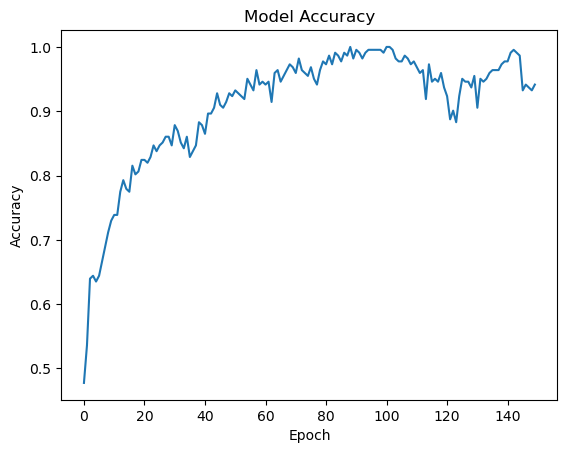

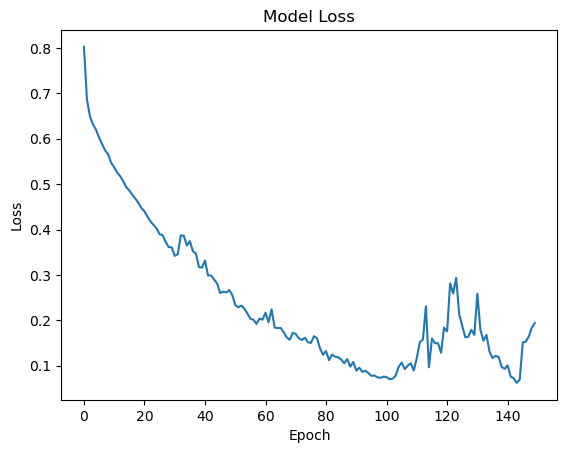

In [60]:
from matplotlib import pyplot as plt
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [61]:
model.save('GP038.keras')